# CONFLUENCE Tutorial: Lumped Basin Workflow (Bow River at Banff)

This notebook walks through a complete workflow for a lumped basin model using the Bow River at Banff as an example. We'll execute each step individually to understand what's happening at each stage.

## Overview of This Tutorial

We'll work through the simplest case in catchment modeling: a lumped basin model. This treats the entire watershed as a single unit, making it an ideal starting point for understanding the CONFLUENCE workflow.

We'll run through:
1. Project setup and configuration
2. Domain definition (watershed delineation)
3. Data acquisition (forcings and attributes)
4. Model preprocessing
5. Model execution
6. Results visualization

## 1. Setup and Import Libraries

In [1]:
# Import required libraries
import sys
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
import contextily as cx
import xarray as xr

# Add CONFLUENCE to path
confluence_path = Path('../').resolve()
sys.path.append(str(confluence_path))

# Import main CONFLUENCE class
from CONFLUENCE import CONFLUENCE

# Set up plotting style
plt.style.use('default')
%matplotlib inline

## 2. Initialize CONFLUENCE
First, let's set up our directories and load the configuration. CONFLUENCE uses a centralized configuration file that controls all aspects of the modeling workflow.

In [3]:
# Set directory paths
CONFLUENCE_CODE_DIR = confluence_path
CONFLUENCE_DATA_DIR = Path('/work/comphyd_lab/data/CONFLUENCE_data')  # ← User should modify this path

# Load and update configuration
config_path = CONFLUENCE_CODE_DIR / '0_config_files' / 'config_template.yaml'

# Read config file and update paths
with open(config_path, 'r') as f:
    config_dict = yaml.safe_load(f)

# Update paths and settings 
config_dict['CONFLUENCE_CODE_DIR'] = str(CONFLUENCE_CODE_DIR)
config_dict['CONFLUENCE_DATA_DIR'] = str(CONFLUENCE_DATA_DIR)

# Save updated config to a temporary file
temp_config_path = CONFLUENCE_CODE_DIR / '0_config_files' / 'config_notebook.yaml'
with open(temp_config_path, 'w') as f:
    yaml.dump(config_dict, f)

# Initialize CONFLUENCE
confluence = CONFLUENCE(temp_config_path)

# Display configuration
print("=== Directory Configuration ===")
print(f"Code Directory: {CONFLUENCE_CODE_DIR}")
print(f"Data Directory: {CONFLUENCE_DATA_DIR}")
print("\n=== Key Configuration Settings ===")
print(f"Domain Name: {confluence.config['DOMAIN_NAME']}")
print(f"Pour Point: {confluence.config['POUR_POINT_COORDS']}")
print(f"Spatial Mode: {confluence.config['SPATIAL_MODE']}")
print(f"Model: {confluence.config['HYDROLOGICAL_MODEL']}")
print(f"Simulation Period: {confluence.config['EXPERIMENT_TIME_START']} to {confluence.config['EXPERIMENT_TIME_END']}")

09:07:17 - INFO - ============================================================


2025-05-13 09:07:17,413 - confluence_general - INFO - ============================================================


09:07:17 - INFO - CONFLUENCE Logging Initialized


2025-05-13 09:07:17,415 - confluence_general - INFO - CONFLUENCE Logging Initialized


09:07:17 - INFO - Domain: Bow_at_Banff_lumped


2025-05-13 09:07:17,416 - confluence_general - INFO - Domain: Bow_at_Banff_lumped


09:07:17 - INFO - Experiment ID: run_1


2025-05-13 09:07:17,418 - confluence_general - INFO - Experiment ID: run_1


09:07:17 - INFO - Log Level: INFO


2025-05-13 09:07:17,419 - confluence_general - INFO - Log Level: INFO


09:07:17 - INFO - Log File: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/_workLog_Bow_at_Banff_lumped/confluence_general_Bow_at_Banff_lumped_20250513_090717.log


2025-05-13 09:07:17,421 - confluence_general - INFO - Log File: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/_workLog_Bow_at_Banff_lumped/confluence_general_Bow_at_Banff_lumped_20250513_090717.log


09:07:17 - INFO - ============================================================


2025-05-13 09:07:17,423 - confluence_general - INFO - ============================================================


09:07:17 - INFO - Configuration logged to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/_workLog_Bow_at_Banff_lumped/config_Bow_at_Banff_lumped_20250513_090717.yaml


2025-05-13 09:07:17,446 - confluence_general - INFO - Configuration logged to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/_workLog_Bow_at_Banff_lumped/config_Bow_at_Banff_lumped_20250513_090717.yaml


09:07:17 - INFO - Initializing CONFLUENCE system


2025-05-13 09:07:17,489 - confluence_general - INFO - Initializing CONFLUENCE system


09:07:17 - INFO - Configuration loaded from: /home/darri.eythorsson/code/CONFLUENCE/0_config_files/config_notebook.yaml


2025-05-13 09:07:17,491 - confluence_general - INFO - Configuration loaded from: /home/darri.eythorsson/code/CONFLUENCE/0_config_files/config_notebook.yaml


09:07:17 - INFO - Initializing VariableHandler for dataset: ERA5 and model: SUMMA


2025-05-13 09:07:17,495 - confluence_general - INFO - Initializing VariableHandler for dataset: ERA5 and model: SUMMA


09:07:17 - INFO - CONFLUENCE system initialized successfully


2025-05-13 09:07:17,831 - confluence_general - INFO - CONFLUENCE system initialized successfully


=== Directory Configuration ===
Code Directory: /home/darri.eythorsson/code/CONFLUENCE
Data Directory: /work/comphyd_lab/data/CONFLUENCE_data

=== Key Configuration Settings ===
Domain Name: Bow_at_Banff_lumped
Pour Point: 51.1722/-115.5717
Spatial Mode: Lumped
Model: SUMMA
Simulation Period: 2018-01-01 01:00 to 2018-12-31 23:00


## 3. Project Setup - Organizing the Modeling Workflow
The first step in any CONFLUENCE workflow is to establish a well-organized project structure. This might seem trivial, but it's crucial for:

- Maintaining consistency across different experiments
- Ensuring all components can find required files
- Enabling reproducibility
- Facilitating collaboration

In [4]:
# Step 1: Project Initialization
print("=== Step 1: Project Initialization ===")

# Setup project
project_dir = confluence.managers['project'].setup_project()

# Create pour point
pour_point_path = confluence.managers['project'].create_pour_point()

# List created directories
print("\nCreated directories:")
for item in sorted(project_dir.iterdir()):
    if item.is_dir():
        print(f"  📁 {item.name}")

print("\nDirectory purposes:")
print("  📁 shapefiles: Domain geometry (watershed, pour points, river network)")
print("  📁 attributes: Static characteristics (elevation, soil, land cover)")
print("  📁 forcing: Meteorological inputs (precipitation, temperature)")
print("  📁 simulations: Model outputs")
print("  📁 evaluation: Performance metrics and comparisons")
print("  📁 plots: Visualizations")
print("  📁 optimisation: Calibration results")

=== Step 1: Project Initialization ===
09:07:32 - INFO - Setting up project for domain: Bow_at_Banff_lumped


2025-05-13 09:07:32,572 - confluence_general - INFO - Setting up project for domain: Bow_at_Banff_lumped


09:07:32 - INFO - Project directory created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped


2025-05-13 09:07:32,658 - confluence_general - INFO - Project directory created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped
2025-05-13 09:07:32,764 - pyogrio._io - INFO - Created 1 records


09:07:32 - INFO - Pour point shapefile created successfully: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/pour_point/Bow_at_Banff_lumped_pourPoint.shp


2025-05-13 09:07:32,769 - confluence_general - INFO - Pour point shapefile created successfully: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/pour_point/Bow_at_Banff_lumped_pourPoint.shp



Created directories:
  📁 _workLog_Bow_at_Banff_lumped
  📁 attributes
  📁 documentation
  📁 evaluation
  📁 forcing
  📁 observations
  📁 optimisation
  📁 plots
  📁 settings
  📁 shapefiles
  📁 simulations

Directory purposes:
  📁 shapefiles: Domain geometry (watershed, pour points, river network)
  📁 attributes: Static characteristics (elevation, soil, land cover)
  📁 forcing: Meteorological inputs (precipitation, temperature)
  📁 simulations: Model outputs
  📁 evaluation: Performance metrics and comparisons
  📁 plots: Visualizations
  📁 optimisation: Calibration results


## 4. Geospatial Domain Definition and Analysis - A data acquisition 
Before we can delineate the watershed, we need elevation data. CONFLUENCE also acquires soil and land cover data at this stage for later use in the model.

In [ ]:
# Step 2: Geospatial Domain Definition and Analysis
print("=== Step 2: Geospatial Domain Definition and Analysis ===")

# Acquire attributes
print("Acquiring geospatial attributes (DEM, soil, land cover)...")
confluence.managers['data'].acquire_attributes()

## 5. Geospatial Domain Definition and Analysis - Delineation 

In [5]:
# Define domain
print(f"\nDelineating watershed using method: {confluence.config['DOMAIN_DEFINITION_METHOD']}")
watershed_path = confluence.managers['domain'].define_domain()

# Check outputs
print("\nDomain definition complete:")
print(f"  - Watershed defined: {watershed_path is not None}")


Delineating watershed using method: lumped
09:07:43 - INFO - Domain definition workflow starting with: lumped


2025-05-13 09:07:43,284 - confluence_general - INFO - Domain definition workflow starting with: lumped


09:07:43 - INFO - Starting geofabric lumped delineation


2025-05-13 09:07:43,286 - confluence_general - INFO - Starting geofabric lumped delineation


09:07:43 - INFO - Geofabric delineation completed successfully


2025-05-13 09:07:43,287 - confluence_general - INFO - Geofabric delineation completed successfully


09:07:43 - INFO - Starting lumped watershed delineation for Bow_at_Banff_lumped


2025-05-13 09:07:43,289 - confluence_general - INFO - Starting lumped watershed delineation for Bow_at_Banff_lumped


PitRemove version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/elevation/dem/domain_Bow_at_Banff_lumped_elv.tif has geographic coordinate system.
Nodata value input to create partition from file: -9999.000000
Nodata value recast to float used in partition raster: -9999.000000


This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.


Processes: 1
Header read time: 0.027816
Data read time: 0.037719
Compute time: 0.284703
Write time: 0.108627
Total time: 0.458865
09:07:44 - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/pitremove -z /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/elevation/dem/domain_Bow_at_Banff_lumped_elv.tif -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/fel.tif


2025-05-13 09:07:44,416 - confluence_general - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/pitremove -z /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/elevation/dem/domain_Bow_at_Banff_lumped_elv.tif -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/fel.tif


D8FlowDir version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/fel.tif has geographic coordinate system.
Nodata value input to create partition from file: -300000000549775575777803994281145270272.000000
Nodata value recast to float used in partition raster: -300000000549775575777803994281145270272.000000


This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.
All slopes evaluated. 28666 flats to resolve.
Draining flats towards lower adjacent terrain
..............................................................................................................
Draining flats away from higher adjacent terrain
.

Processors: 1
Header read time: 0.024765
Data read time: 0.036577
Compute Slope time: 0.287108
Write Slope time: 0.150268
Resolve Flat time: 0.704694
Write Flat time: 0.045368
Total time: 1.248779
09:07:46 - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/d8flowdir -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/fel.tif -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -sd8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/sd8.tif


.....
Setting directions
Iteration complete. Number of flats remaining: 95
Draining flats towards lower adjacent terrain
...
Draining flats away from higher adjacent terrain
..
Setting directions
2025-05-13 09:07:46,096 - confluence_general - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/d8flowdir -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/fel.tif -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -sd8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/sd8.tif


AreaD8 version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768


This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.


Number of Processes: 1
Read time: 0.052965
Compute time: 0.330562
Write time: 0.084945
Total time: 0.468471
09:07:47 - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/aread8 -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -ad8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/ad8.tif


2025-05-13 09:07:47,022 - confluence_general - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/aread8 -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -ad8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/ad8.tif


Threshold version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/ad8.tif has geographic coordinate system.
Nodata value input to create partition from file: -1.000000
Nodata value recast to float used in partition raster: -1.000000
Compute time: 0.017535
09:07:47 - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/threshold -ssa /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/ad8.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/src.tif -thresh 100


This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.
2025-05-13 09:07:47,541 - confluence_general - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/threshold -ssa /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/ad8.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/src.tif -thresh 100


MoveOutletsToStreams version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/src.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
om Total time: 0.073068
09:07:48 - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/moveoutletstostrm -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/src.tif -o /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/pour_poin

This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.
2025-05-13 09:07:48,088 - confluence_general - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/moveoutletstostrm -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/src.tif -o /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/pour_point/Bow_at_Banff_lumped_pourPoint.shp -om /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/om.shp


Gage Watershed version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Size: 1
Read time: 0.042969
Compute time: 0.069850
Write time: 0.048279
Total time: 0.161098
09:07:48 - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/gagewatershed -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -o /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/om.shp -gw /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/watershed.tif -id /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/watershed_id.txt


This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.
2025-05-13 09:07:48,668 - confluence_general - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/gagewatershed -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -o /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/om.shp -gw /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/watershed.tif -id /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/watershed_id.txt
2025-05-13 09:07:48,762 - pyogrio._io - INFO - Created 1 records


09:07:48 - INFO - Removed temporary file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped_temp.shp


2025-05-13 09:07:48,770 - confluence_general - INFO - Removed temporary file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped_temp.shp


09:07:48 - INFO - Removed temporary file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped_temp.shx


2025-05-13 09:07:48,772 - confluence_general - INFO - Removed temporary file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped_temp.shx


09:07:48 - INFO - Removed temporary file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped_temp.dbf


2025-05-13 09:07:48,775 - confluence_general - INFO - Removed temporary file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped_temp.dbf


09:07:48 - INFO - Filtered watershed shapefile created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped.shp


2025-05-13 09:07:48,777 - confluence_general - INFO - Filtered watershed shapefile created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped.shp
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-13 09:07:48,955 - pyogrio._io - INFO - Created 1 records


09:07:48 - INFO - Updated watershed shapefile at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped.shp


2025-05-13 09:07:48,959 - confluence_general - INFO - Updated watershed shapefile at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped.shp
2025-05-13 09:07:48,980 - pyogrio._io - INFO - Created 1 records


09:07:48 - INFO - Created river network shapefile at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_network/Bow_at_Banff_lumped_riverNetwork_lumped.shp


2025-05-13 09:07:48,982 - confluence_general - INFO - Created river network shapefile at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_network/Bow_at_Banff_lumped_riverNetwork_lumped.shp
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-13 09:07:49,002 - pyogrio._io - INFO - Created 1 records


09:07:49 - INFO - Updated river basins shapefile with required fields at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped.shp


2025-05-13 09:07:49,005 - confluence_general - INFO - Updated river basins shapefile with required fields at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped.shp
2025-05-13 09:07:49,022 - pyogrio._io - INFO - Created 1 records


09:07:49 - INFO - Updated river network shapefile with required fields at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_network/Bow_at_Banff_lumped_riverNetwork_lumped.shp


2025-05-13 09:07:49,025 - confluence_general - INFO - Updated river network shapefile with required fields at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_network/Bow_at_Banff_lumped_riverNetwork_lumped.shp


09:07:49 - INFO - Domain definition completed using method: lumped


2025-05-13 09:07:49,027 - confluence_general - INFO - Domain definition completed using method: lumped


09:07:49 - INFO - Creating domain visualization...


2025-05-13 09:07:49,028 - confluence_general - INFO - Creating domain visualization...


09:07:50 - INFO - Domain map saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/plots/domain/domain_map.png


2025-05-13 09:07:50,066 - confluence_general - INFO - Domain map saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/plots/domain/domain_map.png


09:07:50 - INFO - Domain visualization created: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/plots/domain/domain_map.png


2025-05-13 09:07:50,068 - confluence_general - INFO - Domain visualization created: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/plots/domain/domain_map.png


09:07:50 - INFO - Domain definition workflow finished


2025-05-13 09:07:50,069 - confluence_general - INFO - Domain definition workflow finished



Domain definition complete:
  - Watershed defined: True


## 6. Geospatial Domain Definition and Analysis - Discretisation 

In [6]:
# Discretize domain
print(f"\nCreating HRUs using method: {confluence.config['DOMAIN_DISCRETIZATION']}")
hru_path = confluence.managers['domain'].discretize_domain()

# Check outputs
print("\nDomain definition complete:")
print(f"  - HRUs created: {hru_path is not None}")


Creating HRUs using method: GRUs
09:07:53 - INFO - Discretizing domain using method: GRUs


2025-05-13 09:07:53,413 - confluence_general - INFO - Discretizing domain using method: GRUs


09:07:53 - INFO - Starting domain discretization using method: grus


2025-05-13 09:07:53,416 - confluence_general - INFO - Starting domain discretization using method: grus


09:07:53 - INFO - Step 1/2: Running discretization method


2025-05-13 09:07:53,417 - confluence_general - INFO - Step 1/2: Running discretization method


09:07:53 - INFO - config domain name Bow_at_Banff_lumped


2025-05-13 09:07:53,419 - confluence_general - INFO - config domain name Bow_at_Banff_lumped


09:07:53 - INFO - Calculating mean elevation for each HRU


2025-05-13 09:07:53,427 - confluence_general - INFO - Calculating mean elevation for each HRU
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
/home/darri.eythorsson/code/CONFLUENCE/utils/geospatial/discretization_utils.py:180: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_utm = gru_gdf.geometry.centroid
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages

09:07:53 - INFO - GRUs saved as HRUs to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment/Bow_at_Banff_lumped_HRUs_GRUs.shp


2025-05-13 09:07:53,805 - confluence_general - INFO - GRUs saved as HRUs to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment/Bow_at_Banff_lumped_HRUs_GRUs.shp


09:07:54 - INFO - HRU plot saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/plots/catchment/Bow_at_Banff_lumped_HRUs_as_GRUs.png


2025-05-13 09:07:54,832 - confluence_general - INFO - HRU plot saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/plots/catchment/Bow_at_Banff_lumped_HRUs_as_GRUs.png


09:07:54 - INFO - Step 2/2: Sorting catchment shape


2025-05-13 09:07:54,834 - confluence_general - INFO - Step 2/2: Sorting catchment shape


09:07:54 - INFO - Sorting catchment shape


2025-05-13 09:07:54,836 - confluence_general - INFO - Sorting catchment shape
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-13 09:07:54,858 - pyogrio._io - INFO - Created 1 records


09:07:54 - INFO - Catchment shape sorted and saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment/Bow_at_Banff_lumped_HRUs_GRUs.shp


2025-05-13 09:07:54,861 - confluence_general - INFO - Catchment shape sorted and saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment/Bow_at_Banff_lumped_HRUs_GRUs.shp


09:07:54 - INFO - Domain discretization completed in 1.45 seconds


2025-05-13 09:07:54,863 - confluence_general - INFO - Domain discretization completed in 1.45 seconds


09:07:54 - ERROR - Domain discretization failed - no shapefile created


2025-05-13 09:07:54,865 - confluence_general - ERROR - Domain discretization failed - no shapefile created



Domain definition complete:
  - HRUs created: False


## 7. Visualize the Delineated Domain
Let's see what our watershed looks like:

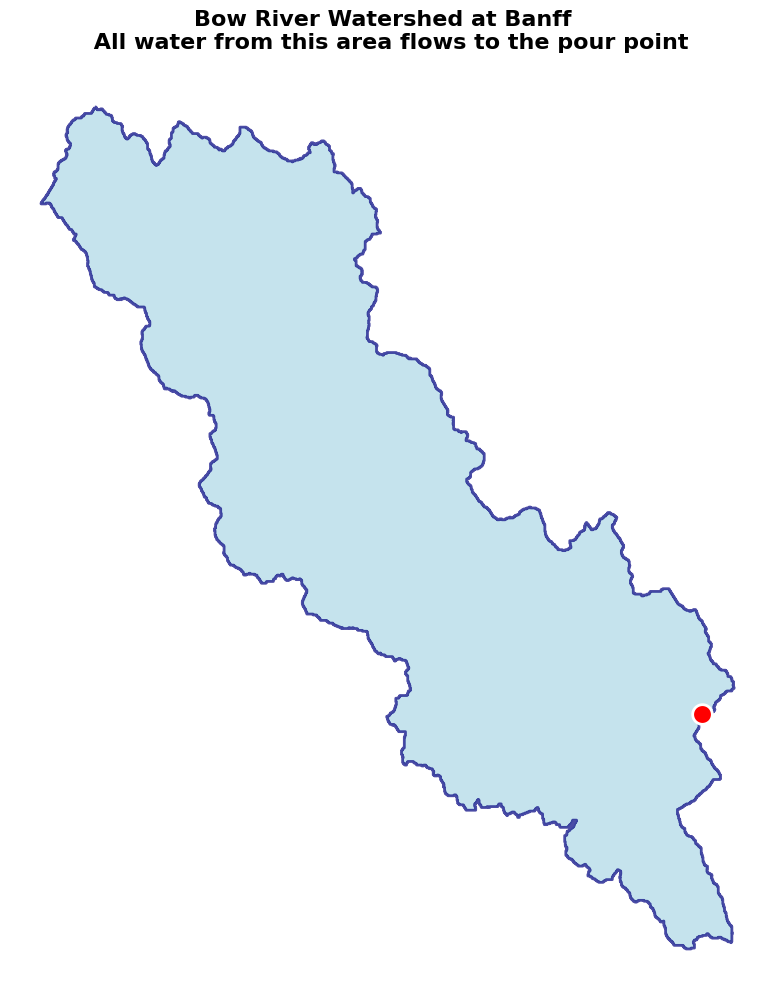

In [11]:
# Visualize the watershed
basin_path = project_dir / 'shapefiles' / 'river_basins'
if basin_path.exists():
    basin_files = list(basin_path.glob('*.shp'))
    
    if basin_files:
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Load watershed and pour point
        basin_gdf = gpd.read_file(basin_files[0])
        pour_point_gdf = gpd.read_file(pour_point_path)
        
        # Reproject for visualization
        basin_web = basin_gdf.to_crs(epsg=3857)
        pour_web = pour_point_gdf.to_crs(epsg=3857)
        
        # Plot watershed
        basin_web.plot(ax=ax, facecolor='lightblue', edgecolor='navy', 
                       linewidth=2, alpha=0.7)
        
        # Add pour point
        pour_web.plot(ax=ax, color='red', markersize=200, marker='o', 
                      edgecolor='white', linewidth=2, zorder=5)
                
        # Set extent
        minx, miny, maxx, maxy = basin_web.total_bounds
        pad = 5000
        ax.set_xlim(minx - pad, maxx + pad)
        ax.set_ylim(miny - pad, maxy + pad)
        
        ax.set_title('Bow River Watershed at Banff \n All water from this area flows to the pour point', 
                    fontsize=16, fontweight='bold', pad=20)
        
        ax.axis('off')
        plt.tight_layout()
        plt.show()

## 8. Model Agnostic Data Pre-Processing - Observed data
For a lumped model, the entire watershed becomes a single Hydrologic Response Unit (HRU). This simplification assumes uniform characteristics across the watershed - obviously an approximation, but useful for many applications.


In [12]:
# Step 3: Model Agnostic Data Pre-Processing
print("=== Step 3: Model Agnostic Data Pre-Processing ===")

# Process observed data
print("Processing observed streamflow data...")
confluence.managers['data'].process_observed_data()

=== Step 3: Model Agnostic Data Pre-Processing ===
Processing observed streamflow data...
09:09:03 - INFO - Processing observed data


2025-05-13 09:09:03,263 - confluence_general - INFO - Processing observed data


09:09:03 - INFO - Processing WSC streamflow data from HYDAT database


2025-05-13 09:09:03,265 - confluence_general - INFO - Processing WSC streamflow data from HYDAT database


09:09:03 - INFO - Querying data from year 2018 to 2025


2025-05-13 09:09:03,270 - confluence_general - INFO - Querying data from year 2018 to 2025


09:09:03 - INFO - Retrieving discharge data for WSC station 05BB001 from HYDAT database


2025-05-13 09:09:03,272 - confluence_general - INFO - Retrieving discharge data for WSC station 05BB001 from HYDAT database


09:09:03 - INFO - Database path: /work/comphyd_lab/data/geospatial-data/hydat/Hydat.sqlite3


2025-05-13 09:09:03,273 - confluence_general - INFO - Database path: /work/comphyd_lab/data/geospatial-data/hydat/Hydat.sqlite3


09:09:03 - INFO - Time period: 2018 to 2025


2025-05-13 09:09:03,275 - confluence_general - INFO - Time period: 2018 to 2025


09:09:03 - INFO - Found station 05BB001 in HYDAT database


2025-05-13 09:09:03,295 - confluence_general - INFO - Found station 05BB001 in HYDAT database


09:09:03 - INFO - Station name: BOW RIVER AT BANFF


2025-05-13 09:09:03,296 - confluence_general - INFO - Station name: BOW RIVER AT BANFF


09:09:03 - INFO - Executing SQL query for daily flows...


2025-05-13 09:09:03,298 - confluence_general - INFO - Executing SQL query for daily flows...


09:09:03 - INFO - Retrieved 72 monthly records from HYDAT


2025-05-13 09:09:03,323 - confluence_general - INFO - Retrieved 72 monthly records from HYDAT


09:09:03 - INFO - Processed 2191 daily flow records


2025-05-13 09:09:03,406 - confluence_general - INFO - Processed 2191 daily flow records


09:09:03 - INFO - Date range: 2018-01-01 00:00:00 to 2023-12-31 00:00:00


2025-05-13 09:09:03,408 - confluence_general - INFO - Date range: 2018-01-01 00:00:00 to 2023-12-31 00:00:00


09:09:03 - INFO - Min flow: 5.809999942779541 m³/s


2025-05-13 09:09:03,410 - confluence_general - INFO - Min flow: 5.809999942779541 m³/s


09:09:03 - INFO - Max flow: 240.0 m³/s


2025-05-13 09:09:03,413 - confluence_general - INFO - Max flow: 240.0 m³/s


09:09:03 - INFO - Mean flow: 38.202441793769964 m³/s


2025-05-13 09:09:03,414 - confluence_general - INFO - Mean flow: 38.202441793769964 m³/s


09:09:04 - INFO - Processed streamflow data saved to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/observations/streamflow/preprocessed/Bow_at_Banff_lumped_streamflow_processed.csv


2025-05-13 09:09:04,154 - confluence_general - INFO - Processed streamflow data saved to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/observations/streamflow/preprocessed/Bow_at_Banff_lumped_streamflow_processed.csv


09:09:04 - INFO - Total rows in processed data: 52561


2025-05-13 09:09:04,156 - confluence_general - INFO - Total rows in processed data: 52561


09:09:04 - INFO - Number of non-null values: 52561


2025-05-13 09:09:04,158 - confluence_general - INFO - Number of non-null values: 52561


09:09:04 - INFO - Number of null values: 0


2025-05-13 09:09:04,160 - confluence_general - INFO - Number of null values: 0


09:09:04 - INFO - Successfully processed WSC data for station 05BB001


2025-05-13 09:09:04,168 - confluence_general - INFO - Successfully processed WSC data for station 05BB001


09:09:04 - INFO - Processing SNOTEL data


2025-05-13 09:09:04,171 - confluence_general - INFO - Processing SNOTEL data


09:09:04 - INFO - SNOTEL data processing is disabled in configuration


2025-05-13 09:09:04,172 - confluence_general - INFO - SNOTEL data processing is disabled in configuration


09:09:04 - INFO - Observed data processing completed successfully


2025-05-13 09:09:04,174 - confluence_general - INFO - Observed data processing completed successfully


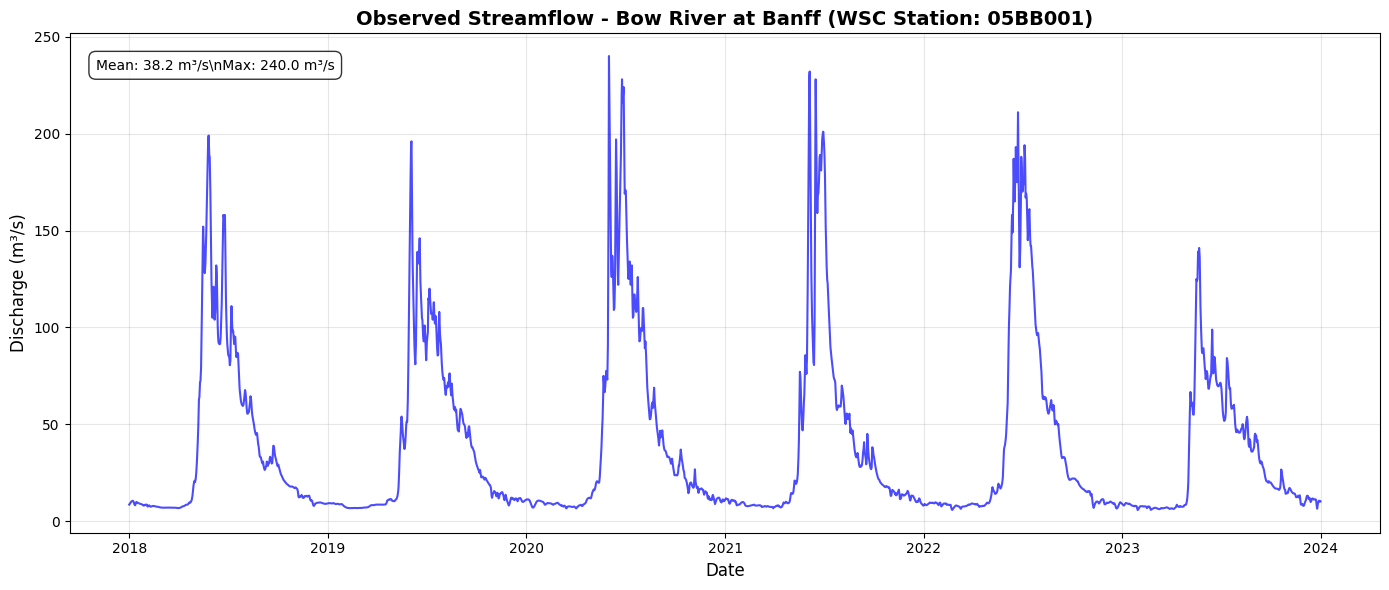

In [13]:
# Visualize observed streamflow data
obs_path = project_dir / 'observations' / 'streamflow' / 'preprocessed' / f"{confluence.config['DOMAIN_NAME']}_streamflow_processed.csv"
if obs_path.exists():
    obs_df = pd.read_csv(obs_path)
    obs_df['datetime'] = pd.to_datetime(obs_df['datetime'])
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(obs_df['datetime'], obs_df['discharge_cms'], 
            linewidth=1.5, color='blue', alpha=0.7)
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Discharge (m³/s)', fontsize=12)
    ax.set_title(f'Observed Streamflow - Bow River at Banff (WSC Station: {confluence.config["STATION_ID"]})', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    ax.text(0.02, 0.95, f'Mean: {obs_df["discharge_cms"].mean():.1f} m³/s\\nMax: {obs_df["discharge_cms"].max():.1f} m³/s', 
            transform=ax.transAxes, 
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8),
            verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

## 9. Model Agnostic Data Pre-Processing - Forcing data

In [ ]:
# Acquire forcings
print(f"\nAcquiring forcing data: {confluence.config['FORCING_DATASET']}")
confluence.managers['data'].acquire_forcings()

## 10. Model Agnostic Data Pre-Processing - Remapping and zonal statistics

In [ ]:
# Run model-agnostic preprocessing
print("\nRunning model-agnostic preprocessing...")
confluence.managers['data'].run_model_agnostic_preprocessing()

## 12. Model-Specific - Preprocessing
Now we prepare inputs specific to our chosen hydrological model (SUMMA in this case). Each model has its own requirements for input format and configuration.

In [14]:
# Step 4: Model Specific Processing and Initialization
print("=== Step 4: Model Specific Processing and Initialization ===")

# Preprocess models
print(f"Preparing {confluence.config['HYDROLOGICAL_MODEL']} input files...")
confluence.managers['model'].preprocess_models()

=== Step 4: Model Specific Processing and Initialization ===
Preparing SUMMA input files...
09:09:16 - INFO - Starting model-specific preprocessing


2025-05-13 09:09:16,158 - confluence_general - INFO - Starting model-specific preprocessing


09:09:16 - INFO - Processing model: SUMMA


2025-05-13 09:09:16,162 - confluence_general - INFO - Processing model: SUMMA


09:09:16 - INFO - Starting SUMMA spatial preprocessing


2025-05-13 09:09:16,166 - confluence_general - INFO - Starting SUMMA spatial preprocessing


09:09:16 - INFO - Starting to apply temperature lapse rate and add data step


2025-05-13 09:09:16,168 - confluence_general - INFO - Starting to apply temperature lapse rate and add data step


09:09:16 - INFO - forcing files: ['Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201801.nc', 'Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201802.nc', 'Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201803.nc', 'Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201804.nc', 'Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201805.nc', 'Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201806.nc', 'Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201807.nc', 'Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201808.nc', 'Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201809.nc', 'Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201810.nc', 'Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201811.nc', 'Bow_at_Banff_lumped

2025-05-13 09:09:16,178 - confluence_general - INFO - forcing files: ['Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201801.nc', 'Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201802.nc', 'Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201803.nc', 'Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201804.nc', 'Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201805.nc', 'Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201806.nc', 'Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201807.nc', 'Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201808.nc', 'Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201809.nc', 'Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_merged_201810.nc', 'Bow_at_Banff_lumped_ERA5_remapped_domain_Bow_at_Banff_lumped_ERA5_mer

09:09:19 - INFO - Completed processing of ERA5 forcing files with temperature lapsing


2025-05-13 09:09:19,570 - confluence_general - INFO - Completed processing of ERA5 forcing files with temperature lapsing


09:09:19 - INFO - Copying SUMMA base settings


2025-05-13 09:09:19,572 - confluence_general - INFO - Copying SUMMA base settings


09:09:19 - INFO - SUMMA base settings copied to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/settings/SUMMA


2025-05-13 09:09:19,614 - confluence_general - INFO - SUMMA base settings copied to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/settings/SUMMA


09:09:19 - INFO - Creating SUMMA file manager


2025-05-13 09:09:19,616 - confluence_general - INFO - Creating SUMMA file manager


09:09:19 - INFO - SUMMA file manager created at /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/settings/SUMMA/fileManager.txt


2025-05-13 09:09:19,628 - confluence_general - INFO - SUMMA file manager created at /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/settings/SUMMA/fileManager.txt


09:09:19 - INFO - Creating forcing file list


2025-05-13 09:09:19,630 - confluence_general - INFO - Creating forcing file list


09:09:19 - INFO - Forcing file list created at /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/settings/SUMMA/forcingFileList.txt


2025-05-13 09:09:19,633 - confluence_general - INFO - Forcing file list created at /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/settings/SUMMA/forcingFileList.txt


09:09:19 - INFO - Creating initial conditions (cold state) file


2025-05-13 09:09:19,635 - confluence_general - INFO - Creating initial conditions (cold state) file


09:09:19 - INFO - Creating initial conditions (cold state) file


2025-05-13 09:09:19,637 - confluence_general - INFO - Creating initial conditions (cold state) file


09:09:19 - INFO - Initial conditions file created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/settings/SUMMA/coldState.nc


2025-05-13 09:09:19,913 - confluence_general - INFO - Initial conditions file created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/settings/SUMMA/coldState.nc


09:09:19 - INFO - Creating trial parameters file


2025-05-13 09:09:19,917 - confluence_general - INFO - Creating trial parameters file


09:09:19 - INFO - Trial parameters file created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/settings/SUMMA/trialParams.nc


2025-05-13 09:09:19,943 - confluence_general - INFO - Trial parameters file created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/settings/SUMMA/trialParams.nc


09:09:19 - INFO - Creating attributes file


2025-05-13 09:09:19,945 - confluence_general - INFO - Creating attributes file


09:09:19 - INFO - Attributes file created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/settings/SUMMA/attributes.nc


2025-05-13 09:09:19,988 - confluence_general - INFO - Attributes file created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/settings/SUMMA/attributes.nc


09:09:19 - INFO - Inserting land class into attributes file


2025-05-13 09:09:19,989 - confluence_general - INFO - Inserting land class into attributes file


09:09:20 - INFO - 0 HRUs were identified as containing only open water. Note that SUMMA skips hydrologic calculations for such HRUs.


2025-05-13 09:09:20,046 - confluence_general - INFO - 0 HRUs were identified as containing only open water. Note that SUMMA skips hydrologic calculations for such HRUs.


09:09:20 - INFO - Inserting soil class into attributes file


2025-05-13 09:09:20,049 - confluence_general - INFO - Inserting soil class into attributes file


09:09:20 - INFO - Inserting elevation into attributes file


2025-05-13 09:09:20,112 - confluence_general - INFO - Inserting elevation into attributes file


09:09:20 - ERROR - Error during SUMMA spatial preprocessing: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment_intersection/with_dem/catchment_with_dem.shp: No such file or directory


2025-05-13 09:09:20,119 - confluence_general - ERROR - Error during SUMMA spatial preprocessing: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment_intersection/with_dem/catchment_with_dem.shp: No such file or directory


09:09:20 - ERROR - Error preprocessing model SUMMA: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment_intersection/with_dem/catchment_with_dem.shp: No such file or directory


2025-05-13 09:09:20,121 - confluence_general - ERROR - Error preprocessing model SUMMA: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment_intersection/with_dem/catchment_with_dem.shp: No such file or directory


09:09:20 - ERROR - Traceback (most recent call last):
  File "/home/darri.eythorsson/code/CONFLUENCE/utils/models/model_manager.py", line 191, in preprocess_models
    preprocessor.run_preprocessing()
  File "/home/darri.eythorsson/code/CONFLUENCE/utils/models/summa_utils.py", line 94, in run_preprocessing
    self.create_attributes_file()
  File "/home/darri.eythorsson/code/CONFLUENCE/utils/models/summa_utils.py", line 751, in create_attributes_file
    self.insert_elevation(attribute_path)
  File "/home/darri.eythorsson/code/CONFLUENCE/utils/models/summa_utils.py", line 851, in insert_elevation
    shp = gpd.read_file(intersect_path / intersect_name)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/geopandas/io/file.py", line 294, in _read_file
    return _read_file_pyogrio(
           ^^^^^^^^^^^^^^^^^^^
  File "/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs

2025-05-13 09:09:20,129 - confluence_general - ERROR - Traceback (most recent call last):
  File "/home/darri.eythorsson/code/CONFLUENCE/utils/models/model_manager.py", line 191, in preprocess_models
    preprocessor.run_preprocessing()
  File "/home/darri.eythorsson/code/CONFLUENCE/utils/models/summa_utils.py", line 94, in run_preprocessing
    self.create_attributes_file()
  File "/home/darri.eythorsson/code/CONFLUENCE/utils/models/summa_utils.py", line 751, in create_attributes_file
    self.insert_elevation(attribute_path)
  File "/home/darri.eythorsson/code/CONFLUENCE/utils/models/summa_utils.py", line 851, in insert_elevation
    shp = gpd.read_file(intersect_path / intersect_name)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/geopandas/io/file.py", line 294, in _read_file
    return _read_file_pyogrio(
           ^^^^^^^^^^^^^^^^^^^
  File "/work/comphyd_lab/users

DataSourceError: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment_intersection/with_dem/catchment_with_dem.shp: No such file or directory

## 13. Model-Specific - Instantiation

In [15]:
# Run models
print(f"\nRunning {confluence.config['HYDROLOGICAL_MODEL']} model...")
confluence.managers['model'].run_models()

print("\nModel run complete")


Running SUMMA model...
09:09:26 - INFO - Starting model runs


2025-05-13 09:09:26,667 - confluence_general - INFO - Starting model runs


09:09:26 - INFO - Running model: SUMMA


2025-05-13 09:09:26,669 - confluence_general - INFO - Running model: SUMMA


09:09:26 - INFO - Starting SUMMA run


2025-05-13 09:09:26,671 - confluence_general - INFO - Starting SUMMA run


09:09:43 - INFO - SUMMA run completed successfully


2025-05-13 09:09:43,568 - confluence_general - INFO - SUMMA run completed successfully


09:09:43 - INFO - SUMMA model run completed successfully


2025-05-13 09:09:43,570 - confluence_general - INFO - SUMMA model run completed successfully


09:09:43 - INFO - Starting model output visualisation


2025-05-13 09:09:43,572 - confluence_general - INFO - Starting model output visualisation


09:09:43 - INFO - Plotting variable: SWRadAtm


2025-05-13 09:09:43,598 - confluence_general - INFO - Plotting variable: SWRadAtm


09:09:45 - INFO - Plotting variable: scalarSWE


2025-05-13 09:09:45,175 - confluence_general - INFO - Plotting variable: scalarSWE


09:09:46 - INFO - Plotting variable: scalarGroundSnowFraction


2025-05-13 09:09:46,670 - confluence_general - INFO - Plotting variable: scalarGroundSnowFraction


09:09:48 - INFO - Plotting variable: scalarTotalRunoff


2025-05-13 09:09:48,172 - confluence_general - INFO - Plotting variable: scalarTotalRunoff


09:09:49 - INFO - Using lumped model output from /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/simulations/run_1/SUMMA/run_1_timestep.nc


2025-05-13 09:09:49,919 - confluence_general - INFO - Using lumped model output from /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/simulations/run_1/SUMMA/run_1_timestep.nc


09:09:50 - INFO - Converted runoff from m/s to m³/s using basin area: 2209951307.64185 m²


2025-05-13 09:09:50,026 - confluence_general - INFO - Converted runoff from m/s to m³/s using basin area: 2209951307.64185 m²


09:09:50 - INFO - Skipping first 36 days (10.0% of total period) as spinup


2025-05-13 09:09:50,030 - confluence_general - INFO - Skipping first 36 days (10.0% of total period) as spinup


09:09:50 - INFO - Using data from 2018-02-06 00:59:59.999986688 to 2018-12-31 23:00:00.000013312


2025-05-13 09:09:50,032 - confluence_general - INFO - Using data from 2018-02-06 00:59:59.999986688 to 2018-12-31 23:00:00.000013312


09:09:52 - INFO - Model runs completed


2025-05-13 09:09:52,627 - confluence_general - INFO - Model runs completed



Model run complete


## 14 Visualisation of results

=== Step 14: Comparing Observed vs. Simulated Streamflow ===
Loading simulated data from: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/simulations/run_1/SUMMA/run_1_timestep.nc
Extracting 'averageRoutedRunoff' variable...
Loading catchment shapefile from: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped.shp
Catchment area: 2209951307.64 m² (2209.95 km²)
Converted runoff from m/s to m³/s (multiplied by basin area)
Loading observed streamflow data from: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/observations/streamflow/preprocessed/Bow_at_Banff_lumped_streamflow_processed.csv
Observed data period: 2018-01-01 00:00:00 to 2023-12-31 00:00:00
Observed streamflow range: 5.81 to 240.00 m³/s
Simulated data period: 2018-01-01 00:59:59.999986688 to 2018-12-31 23:00:00.000013312
Simulated streamflow range: 13.86 to 13634.96 m³/s

Common data period: 2018-01-01 00:00:00 to 20

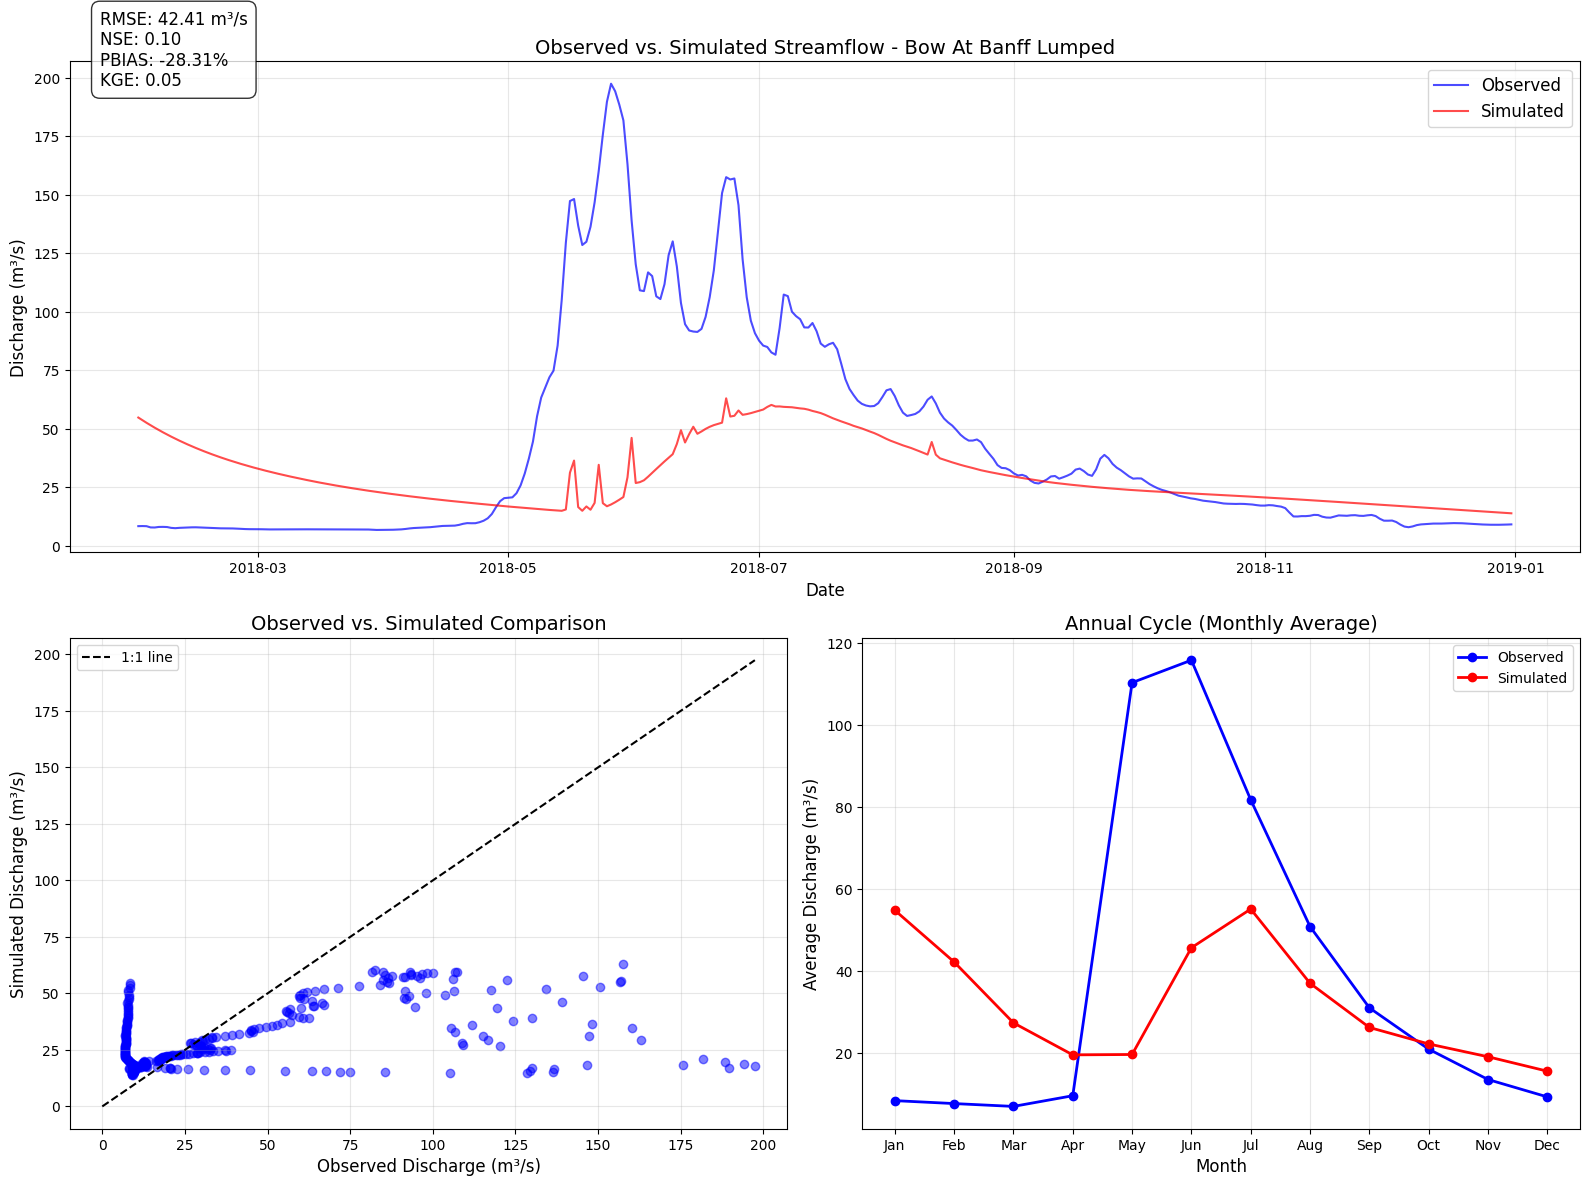

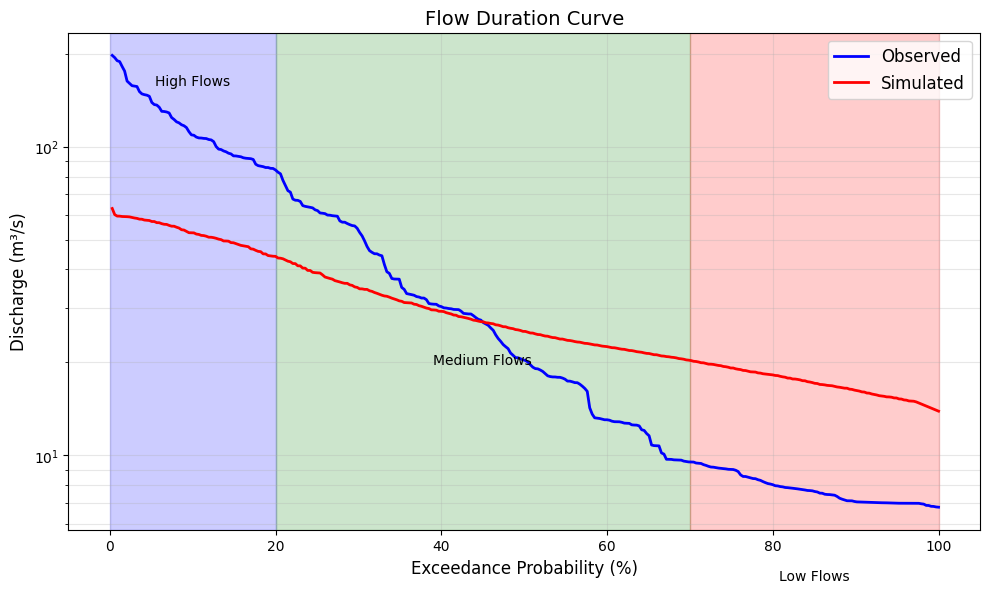


Streamflow visualization complete


In [19]:
# Step 14: Visualize Observed vs. Simulated Streamflow
print("=== Step 14: Comparing Observed vs. Simulated Streamflow ===")
import numpy as np 

# 1. Load the observed streamflow data
obs_path = project_dir / 'observations' / 'streamflow' / 'preprocessed' / f"{confluence.config['DOMAIN_NAME']}_streamflow_processed.csv"
if not obs_path.exists():
    print(f"Warning: Observed streamflow data not found at {obs_path}")
    print("Checking for alternative locations...")
    alt_paths = list(Path(config_dict['CONFLUENCE_DATA_DIR']).glob(f"**/observations/streamflow/preprocessed/*_streamflow_processed.csv"))
    if alt_paths:
        obs_path = alt_paths[0]
        print(f"Found alternative streamflow data at: {obs_path}")
    else:
        print("No observed streamflow data found. Only simulated data will be displayed.")

# 2. Load the simulated streamflow data from SUMMA output
sim_path = Path(config_dict['CONFLUENCE_DATA_DIR']) / f"domain_{config_dict['DOMAIN_NAME']}" / "simulations" / config_dict['EXPERIMENT_ID'] / "SUMMA" / f"{config_dict['EXPERIMENT_ID']}_timestep.nc"

# Check for alternative NetCDF file patterns if not found
if not sim_path.exists():
    print(f"Simulated data not found at {sim_path}")
    print("Checking for alternative NetCDF files...")
    alt_sim_paths = list(Path(config_dict['CONFLUENCE_DATA_DIR']).glob(
        f"domain_{config_dict['DOMAIN_NAME']}/simulations/{config_dict['EXPERIMENT_ID']}/SUMMA/*.nc"))
    
    if alt_sim_paths:
        sim_path = alt_sim_paths[0]
        print(f"Found alternative simulation data at: {sim_path}")
    else:
        raise FileNotFoundError(f"No simulation results found for experiment {config_dict['EXPERIMENT_ID']}")

# Load simulated data
print(f"Loading simulated data from: {sim_path}")
ds = xr.open_dataset(sim_path)

# Extract averageRoutedRunoff
print("Extracting 'averageRoutedRunoff' variable...")
if 'averageRoutedRunoff' in ds:
    # Extract and convert to DataFrame
    sim_runoff = ds['averageRoutedRunoff'].to_dataframe().reset_index()
    
    # Get catchment area from the river basin shapefile to convert from m/s to m³/s
    basin_shapefile = config_dict.get('RIVER_BASINS_NAME', 'default')
    if basin_shapefile == 'default':
        basin_shapefile = f"{config_dict['DOMAIN_NAME']}_riverBasins_{config_dict.get('DOMAIN_DEFINITION_METHOD', 'lumped')}.shp"
    
    basin_path = project_dir / "shapefiles" / "river_basins" / basin_shapefile
    
    try:
        print(f"Loading catchment shapefile from: {basin_path}")
        basin_gdf = gpd.read_file(basin_path)
        area_col = config_dict.get('RIVER_BASIN_SHP_AREA', 'GRU_area')
        
        # Area should be in m²
        if area_col in basin_gdf.columns:
            area_m2 = basin_gdf[area_col].sum()
            print(f"Catchment area: {area_m2:.2f} m² ({area_m2/1e6:.2f} km²)")
            
            # Convert from m/s to m³/s by multiplying by area in m²
            # Assuming first GRU for lumped basin simulation if multiple GRUs exist
            if 'gru' in sim_runoff.columns:
                sim_runoff = sim_runoff[sim_runoff['gru'] == 1][['time', 'averageRoutedRunoff']]
            else:
                sim_runoff = sim_runoff[['time', 'averageRoutedRunoff']]
            
            # Convert units: m/s -> m³/s
            sim_runoff['discharge_cms'] = sim_runoff['averageRoutedRunoff'] * area_m2
            print(f"Converted runoff from m/s to m³/s (multiplied by basin area)")
        else:
            print(f"Warning: Area column '{area_col}' not found in catchment shapefile")
            sim_runoff['discharge_cms'] = sim_runoff['averageRoutedRunoff']  # Use raw values as fallback
    except Exception as e:
        print(f"Error getting basin area: {str(e)}. Using raw values.")
        sim_runoff['discharge_cms'] = sim_runoff['averageRoutedRunoff']  # Use raw values as fallback
    
    # Set index to time for easier processing
    sim_runoff.set_index('time', inplace=True)
    sim_df = sim_runoff[['discharge_cms']]
else:
    print("Warning: 'averageRoutedRunoff' variable not found in the SUMMA output")
    print("Available variables:", list(ds.data_vars))
    raise ValueError("Required 'averageRoutedRunoff' variable not found in SUMMA output")

# Load observed data
obs_df = None
if obs_path.exists():
    print(f"Loading observed streamflow data from: {obs_path}")
    obs_df = pd.read_csv(obs_path)
    obs_df['datetime'] = pd.to_datetime(obs_df['datetime'])
    obs_df.set_index('datetime', inplace=True)
    print(f"Observed data period: {obs_df.index.min()} to {obs_df.index.max()}")
    print(f"Observed streamflow range: {obs_df['discharge_cms'].min():.2f} to {obs_df['discharge_cms'].max():.2f} m³/s")

# Show simulated data info
print(f"Simulated data period: {sim_df.index.min()} to {sim_df.index.max()}")
print(f"Simulated streamflow range: {sim_df['discharge_cms'].min():.2f} to {sim_df['discharge_cms'].max():.2f} m³/s")

# Find common date range if observed data exists
if obs_df is not None:
    # Ensure same frequency for both datasets
    obs_daily = obs_df.resample('D').mean()  # Daily mean if multiple obs per day
    sim_daily = sim_df.resample('D').mean()  # Daily mean if sub-daily sim data
    
    # Find common date range
    start_date = max(obs_daily.index.min(), sim_daily.index.min())
    end_date = min(obs_daily.index.max(), sim_daily.index.max())
    
    print(f"\nCommon data period: {start_date} to {end_date}")

    # Advance the start date to skip the initial spinup
    start_date = start_date + pd.Timedelta(days=30)
    
    # Filter to common period
    obs_period = obs_daily.loc[start_date:end_date]
    sim_period = sim_daily.loc[start_date:end_date]
    
    # Calculate performance metrics
    # Calculate root mean square error (RMSE)
    rmse = ((obs_period['discharge_cms'] - sim_period['discharge_cms'])**2).mean()**0.5
    
    # Calculate Nash-Sutcliffe Efficiency (NSE)
    mean_obs = obs_period['discharge_cms'].mean()
    numerator = ((obs_period['discharge_cms'] - sim_period['discharge_cms'])**2).sum()
    denominator = ((obs_period['discharge_cms'] - mean_obs)**2).sum()
    nse = 1 - (numerator / denominator)
    
    # Calculate Percent Bias (PBIAS)
    pbias = 100 * (sim_period['discharge_cms'].sum() - obs_period['discharge_cms'].sum()) / obs_period['discharge_cms'].sum()
    
    # Calculate Kling-Gupta Efficiency (KGE)
    r = obs_period['discharge_cms'].corr(sim_period['discharge_cms'])  # Correlation
    alpha = sim_period['discharge_cms'].std() / obs_period['discharge_cms'].std()  # Relative variability
    beta = sim_period['discharge_cms'].mean() / obs_period['discharge_cms'].mean()  # Bias ratio
    kge = 1 - ((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)**0.5
    
    print(f"Performance metrics:")
    print(f"  - RMSE: {rmse:.2f} m³/s")
    print(f"  - NSE: {nse:.2f}")
    print(f"  - PBIAS: {pbias:.2f}%")
    print(f"  - KGE: {kge:.2f}")
    
    # Create visualizations
    plt.figure(figsize=(16, 12))
    
    # 1. Time Series Plot - Full Period
    plt.subplot(2, 1, 1)
    plt.plot(obs_period.index, obs_period['discharge_cms'], 'b-', label='Observed', linewidth=1.5, alpha=0.7)
    plt.plot(sim_period.index, sim_period['discharge_cms'], 'r-', label='Simulated', linewidth=1.5, alpha=0.7)
    
    plt.title(f'Observed vs. Simulated Streamflow - {config_dict["DOMAIN_NAME"].replace("_", " ").title()}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Discharge (m³/s)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    
    # Add performance metrics as text box
    plt.text(0.02, 0.95, 
             f"RMSE: {rmse:.2f} m³/s\nNSE: {nse:.2f}\nPBIAS: {pbias:.2f}%\nKGE: {kge:.2f}",
             transform=plt.gca().transAxes, 
             fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    # 2. Scatter Plot with 1:1 line
    plt.subplot(2, 2, 3)
    plt.scatter(obs_period['discharge_cms'], sim_period['discharge_cms'], alpha=0.5, color='blue')
    
    # Add 1:1 line
    max_val = max(obs_period['discharge_cms'].max(), sim_period['discharge_cms'].max())
    plt.plot([0, max_val], [0, max_val], 'k--', label='1:1 line')
    
    plt.title('Observed vs. Simulated Comparison', fontsize=14)
    plt.xlabel('Observed Discharge (m³/s)', fontsize=12)
    plt.ylabel('Simulated Discharge (m³/s)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 3. Annual cycle plot - by month
    plt.subplot(2, 2, 4)
    
    # Calculate monthly means
    obs_monthly = obs_period.groupby(obs_period.index.month)['discharge_cms'].mean()
    sim_monthly = sim_period.groupby(sim_period.index.month)['discharge_cms'].mean()
    
    # Get month names for x-axis
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Plot
    plt.plot(range(1, 13), obs_monthly.reindex(range(1, 13)), 'b-o', label='Observed', linewidth=2)
    plt.plot(range(1, 13), sim_monthly.reindex(range(1, 13)), 'r-o', label='Simulated', linewidth=2)
    
    plt.title('Annual Cycle (Monthly Average)', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Average Discharge (m³/s)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(range(1, 13), month_names)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Create Flow Duration Curve
    plt.figure(figsize=(10, 6))
    
    # Sort values in descending order
    obs_sorted = obs_period['discharge_cms'].sort_values(ascending=False)
    sim_sorted = sim_period['discharge_cms'].sort_values(ascending=False)
    
    # Calculate exceedance probabilities
    obs_ranks = np.arange(1., len(obs_sorted) + 1) / len(obs_sorted)
    sim_ranks = np.arange(1., len(sim_sorted) + 1) / len(sim_sorted)
    
    # Plot Flow Duration Curves
    plt.semilogy(obs_ranks * 100, obs_sorted, 'b-', label='Observed', linewidth=2)
    plt.semilogy(sim_ranks * 100, sim_sorted, 'r-', label='Simulated', linewidth=2)
    
    plt.title('Flow Duration Curve', fontsize=14)
    plt.xlabel('Exceedance Probability (%)', fontsize=12)
    plt.ylabel('Discharge (m³/s)', fontsize=12)
    plt.grid(True, which='both', alpha=0.3)
    plt.legend(fontsize=12)
    
    # Add low, medium and high flow regions
    plt.axvspan(0, 20, alpha=0.2, color='blue', label='High Flows')
    plt.axvspan(20, 70, alpha=0.2, color='green', label='Medium Flows')
    plt.axvspan(70, 100, alpha=0.2, color='red', label='Low Flows')
    
    # Add text labels for flow regions
    plt.text(10, max(obs_sorted.max(), sim_sorted.max()) * 0.8, 'High Flows', fontsize=10, ha='center')
    plt.text(45, max(obs_sorted.max(), sim_sorted.max()) * 0.1, 'Medium Flows', fontsize=10, ha='center')
    plt.text(85, max(obs_sorted.max(), sim_sorted.max()) * 0.02, 'Low Flows', fontsize=10, ha='center')
    
    plt.tight_layout()
    plt.show()

else:
    # If no observed data, just plot simulated
    plt.figure(figsize=(14, 6))
    plt.plot(sim_df.index, sim_df['discharge_cms'], '-', label='Simulated Streamflow', color='blue', linewidth=1.5)
    plt.title(f"Simulated Streamflow - {config_dict['DOMAIN_NAME'].replace('_', ' ').title()}", fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Discharge (m³/s)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Close the dataset
ds.close()

print("\nStreamflow visualization complete")

## 11. Model Agnostic Data Pre-Processing - Benchmarking

In [ ]:
# Run benchmarking
print("\nRunning benchmarking analysis...")
benchmark_results = confluence.managers['analysis'].run_benchmarking()

## 14. Optional Steps - Optimization and Analysis

In [20]:
# Step 5 & 6: Optional Steps (Optimization and Analysis)
print("=== Step 5 & 6: Optional Steps ===")


=== Step 5 & 6: Optional Steps ===


## Alternative - Run Complete Workflow

In [ ]:
# Alternative: Run the complete workflow in one step
# (Uncomment to use this instead of the step-by-step approach)

# confluence.run_workflow()

## Summary: Understanding the CONFLUENCE Workflow
Congratulations! You've completed a full lumped basin modeling workflow with CONFLUENCE. 

## Next Steps You Could Try:

### Experiment with different models (change HYDROLOGICAL_MODEL)
- Try distributed modeling (change SPATIAL_MODE to 'Distributed')
- Calibrate the model (use the optimization module)
- Analyze model sensitivity to different parameters
- Compare multiple model structures (decision analysis)
